<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/003_TensorFlow_Proj_Three_FFNN_PolynomialCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [1]:
# utils
import itertools
import glob, os, sys, shutil
import math
import numpy as np
import pandas as pd
from random import (randint, sample, choice)
# google
from google.colab import drive
# display
from IPython.display import Image
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, load_model)
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPool2D,
                                     AvgPool2D, Activation, Input,
                                     BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (CategoricalCrossentropy,
                                      SparseCategoricalCrossentropy,
                                      BinaryCrossentropy)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
# matplotlib
import matplotlib.pyplot as plt

## Setup

In [2]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

GPU memory growth set for device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## BiLinear Model

In [79]:
# gen sample
def bi_linear(samples):
  # red points
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue points
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # stack and return df
  final= np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])

# define colors
color_dict = {0: 'red', 1: 'blue'}
# train df
n_train =1000
train_df = bi_linear(n_train)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
n_test = 200
test_df = bi_linear(n_test)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save data frames
graph = 'linear'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

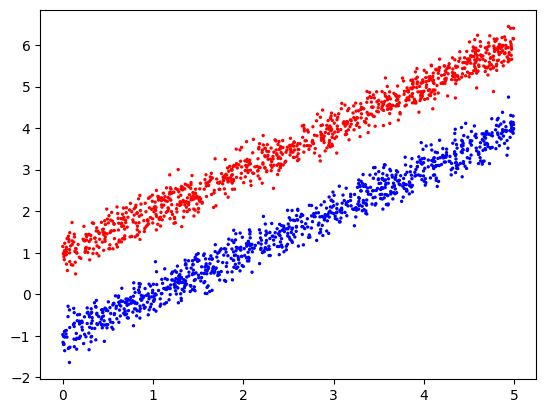

In [80]:
# plot
plt.figure()
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)
plt.show()

In [81]:
# shuffle
np.random.shuffle(train_df.values)

In [82]:
print(train_df.head())

          x         y color
0  0.949859  2.309862   red
1  4.574253  5.581247   red
2  3.327437  4.478525   red
3  0.012960  0.908407   red
4  0.464477  1.769838   red


In [83]:
# shallow N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values
test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6824 - loss: 0.5979
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8810 - loss: 0.4779
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9364 - loss: 0.4039
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.3512
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9900 - loss: 0.3118
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9980 - loss: 0.2779
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.2485
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 1.0000 - loss: 0.2080
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.1840
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9986 - loss: 0.1640
EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1372


[0.14597053825855255, 1.0]

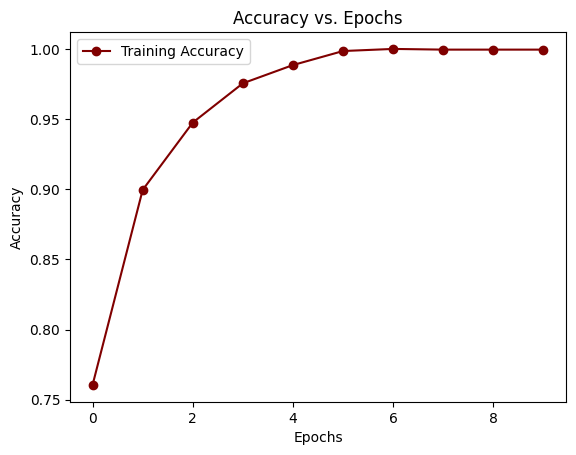

In [84]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='maroon', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## TriLines Model

In [99]:
def three_lines(samples):
  # red
  x1 = np.random.uniform(0,5, samples)
  y1 = x1 + np.random.normal(1,0.25, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue
  x2 = np.random.uniform(0,5,samples)
  y2 = x2 - np.random.normal(1,0.25, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # green
  x3 = np.random.uniform(0,5,samples)
  y3 = x3 - np.random.normal(5,0.25, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # stack and return
  final= np.row_stack((red,blue,green))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue', 2: 'green'}
# train df
train_df = three_lines(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
test_df = three_lines(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save data frames
graph = 'linear_multigroup'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

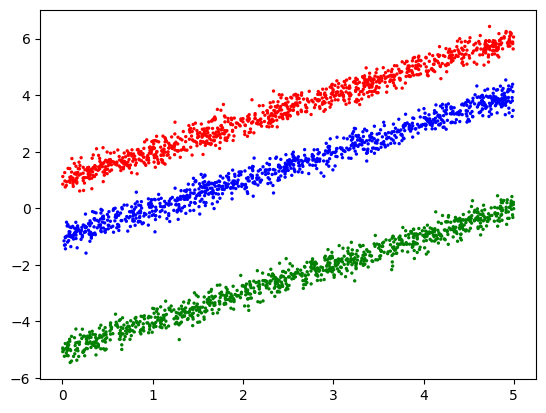

In [100]:
# plot
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [101]:
# shuffle
np.random.shuffle(train_df.values)

In [102]:
print(train_df.head())

          x         y color
0  4.480880  5.589564   red
1  3.125460  3.800320   red
2  0.951627  1.781025   red
3  1.092777  1.871416   red
4  3.128683  4.483858   red


In [103]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(3, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="categorical_crossentropy",
	          metrics=['accuracy'])
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=False).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=False).values
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10)
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4215 - loss: 1.1066
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5746 - loss: 0.8210
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6425 - loss: 0.6933
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - loss: 0.6144
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8158 - loss: 0.5418
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8622 - loss: 0.4710
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9079 - loss: 0.4078
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9360 - loss: 0.3665
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.3298
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9813 - loss: 0.2748
EVALUATION
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9974 - loss: 0.2792


[0.2326645702123642, 0.996666669845581]

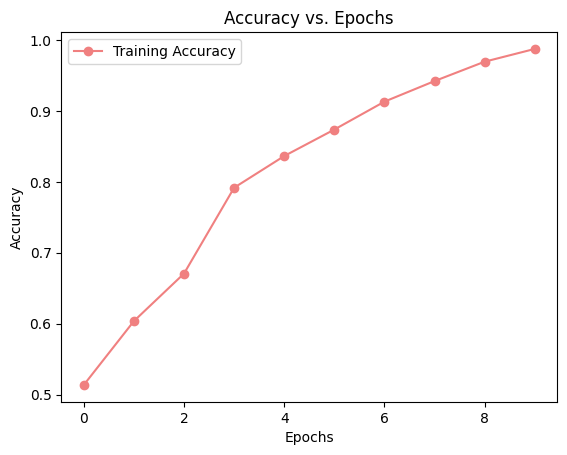

In [104]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='lightcoral', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Quadratic Model

In [105]:
def quadratic(samples):
  # Red
  x1 = np.random.uniform(-5,5, samples)
  y1 = x1**2 + np.random.uniform(1,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # Blue
  x2 = np.random.uniform(-5,5,samples)
  y2 = x2**2 - np.random.uniform(1,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # Stack and return
  final = np.row_stack((red,blue))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue'}
# Train df
train_df = quadratic(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# Test df
test_df = quadratic(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# Save data frames
graph = 'quadratic'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

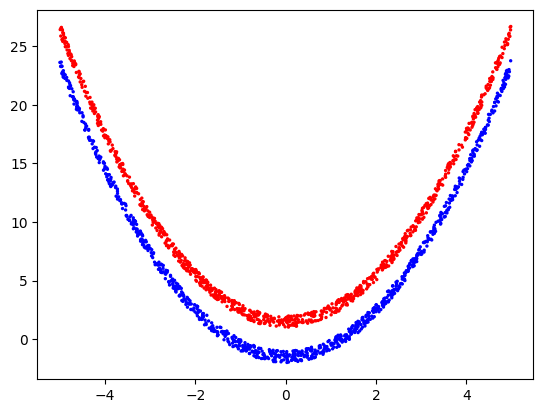

In [106]:
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [107]:
# shuffle
np.random.shuffle(train_df.values)

In [108]:
print(train_df.head())

          x          y color
0  2.372279   7.021393   red
1  1.029880   2.340820   red
2  0.373698   1.424958   red
3  3.397092  13.360890   red
4  1.106650   2.654639   red


In [109]:
# deep N.N. model
model = keras.Sequential([
	keras.layers.Dense(8, input_shape=(2,), activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(2, activation="softmax")])
# complie model
model.compile(optimizer=Adam(learning_rate=1e-4),
	          loss="sparse_categorical_crossentropy",
	          metrics=['accuracy'])
# stack x and y in np.array
train_x = np.column_stack((train_df.x.values, train_df.y.values))
train_y = pd.get_dummies(train_df.color, drop_first=True).values

test_x = np.column_stack((test_df.x.values, test_df.y.values))
test_y = pd.get_dummies(test_df.color, drop_first=True).values
# fit model
hist = model.fit(train_x, train_y, batch_size=5, epochs=10               )
# evaluation
print("EVALUATION")
model.evaluate(test_x, test_y)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5813 - loss: 0.6935
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6570 - loss: 0.6533
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7128 - loss: 0.6142
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7178 - loss: 0.5629
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7909 - loss: 0.5193
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8283 - loss: 0.4861
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8465 - loss: 0.4510
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8713 - loss: 0.4233
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8899 - loss: 0.4027
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9112 - loss: 0.3626
EVALUATION
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9531 - loss: 0.3718


[0.36036360263824463, 0.8899999856948853]

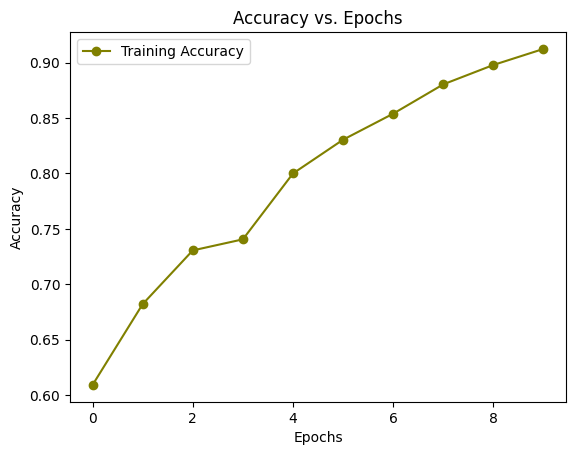

In [110]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='olive', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Cluster  Model

In [138]:
def clusters(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  blue = np.column_stack((x2,y2,z2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  green = np.column_stack((x3,y3,z3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  teal = np.column_stack((x4,y4,z4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  orange = np.column_stack((x5,y5,z5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  purple = np.column_stack((x6,y6,z6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color'])
# color code
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
# train df
train_df = clusters(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
# test df
test_df = clusters(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
# save frames
graph = 'clusters_multi_categories'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

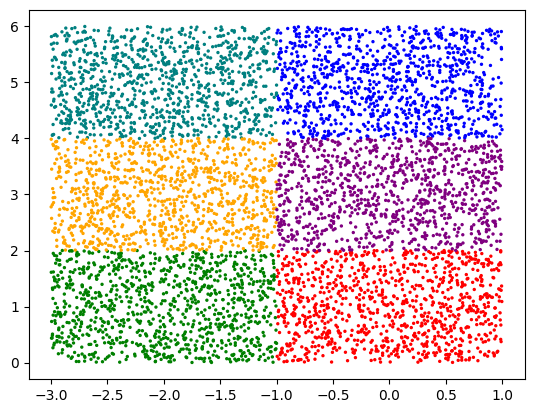

In [139]:
plt.scatter(train_df.x, train_df.y, color=train_df.color, s=2)

In [140]:
# enumerate colors
color_dict = {'red': 0, 'blue': 1, 'green': 2, 'teal': 3, 'orange': 4, 'purple': 5}
train_df['color'] = train_df.color.apply(lambda x: color_dict[x])

In [141]:
# shuffle
np.random.shuffle(train_df.values)
print(train_df.head())
print(train_df.color.unique())

          x         y  color
0 -0.947005  1.764709      0
1  0.738582  1.431491      0
2  0.686663  1.884038      0
3 -0.004572  0.114989      0
4 -0.535700  0.561202      0
[0 1 2 3 4 5]


In [142]:
# stack features
train_x = np.column_stack((train_df.x.values, train_df.y.values))
test_x = np.column_stack((test_df.x.values, test_df.y.values))

In [143]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(6, activation='softmax')])
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(train_x, train_df.color.values, batch_size=5, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5961 - loss: 1.0304
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9457 - loss: 0.1971
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9600 - loss: 0.1306
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9653 - loss: 0.1076
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9616 - loss: 0.0999
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9696 - loss: 0.0876
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9676 - loss: 0.0829
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9739 - loss: 0.0750
Epoch 9/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9716 - loss: 0.0720
Epoch 10/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9710 - loss: 0.0689


In [144]:
# evaluate
print("EVALUATION")
test_df['color'] = test_df.color.apply(lambda x: color_dict[x])
model.evaluate(test_x, test_df.color.values)
print("Prediction", np.round(model.predict(np.array([[0,3]]))))

EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9899 - loss: 0.0397
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Prediction [[0. 0. 0. 0. 0. 1.]]


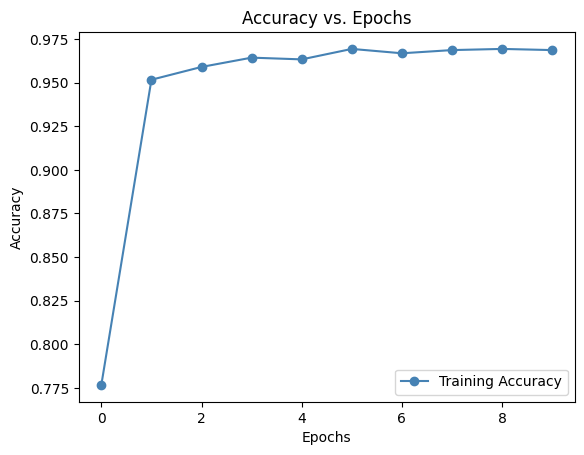

In [145]:
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='steelblue', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

## Cluster Model - OneHot Encoder

In [146]:
def clusters_advanced(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])

# color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}

# train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

In [147]:
# one-hot encoders
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))

In [148]:
# shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)

In [149]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(64, activation='relu'),
  keras.layers.Dropout(0.4),
 	keras.layers.Dense(32, activation='relu'),
  keras.layers.Dropout(0.2),
	keras.layers.Dense(16, activation='relu'),
  keras.layers.Dropout(0.4),
	keras.layers.Dense(9, activation='sigmoid')])
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(x, train_labels, batch_size=10, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0523 - loss: 0.5185
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0624 - loss: 0.3218
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1416 - loss: 0.2462
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2173 - loss: 0.2124
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2713 - loss: 0.1888
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2622 - loss: 0.1694
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2844 - loss: 0.1611
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2700 - loss: 0.1530
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2625 - loss: 0.1415
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2656 - loss: 0.1303


In [150]:
# evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))

EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5990 - loss: 0.0403


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Prediction [[0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0.]]


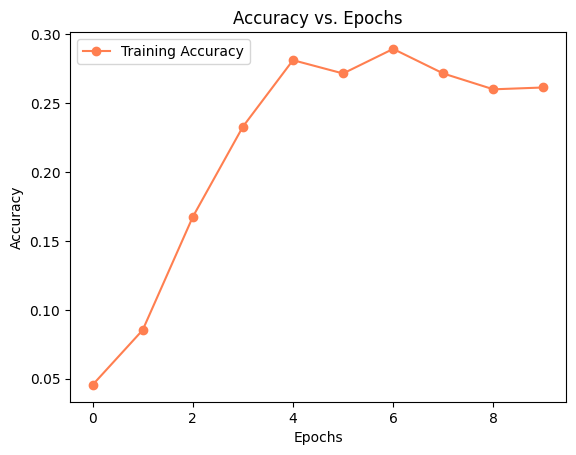

In [151]:
# plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='coral', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

# Cluster Model - Advanced

In [152]:
def clusters_advanced(samples):
  # red
  x1 = np.random.uniform(-1, 1, samples)
  y1 = np.random.uniform(0,2, samples)
  z1 = np.zeros(y1.shape)
  m1 = np.zeros(y1.shape)
  red = np.column_stack((x1,y1,z1,m1))
  # blue
  x2 = np.random.uniform(-1, 1, samples)
  y2 = 4 + np.random.uniform(0,2, samples)
  z2 = np.ones(y2.shape)
  m2 = np.zeros(y2.shape)
  blue = np.column_stack((x2,y2,z2,m2))
  # green
  x3 = np.random.uniform(-3, -1, samples)
  y3 = np.random.uniform(0,2, samples)
  z3 = np.ones(y3.shape)*2
  m3 = np.ones(y3.shape)
  green = np.column_stack((x3,y3,z3,m3))
  # teal
  x4 = np.random.uniform(-3, -1, samples)
  y4 = 4 + np.random.uniform(0,2, samples)
  z4 = np.ones(y4.shape)*3
  m4 = np.ones(y4.shape)
  teal = np.column_stack((x4,y4,z4,m4))
  # orange
  x5 = np.random.uniform(-3, -1, samples)
  y5 = 2 + np.random.uniform(0,2, samples)
  z5 = np.ones(y5.shape)*4
  m5 = np.ones(y5.shape)
  orange = np.column_stack((x5,y5,z5,m5))
  # purple
  x6 = np.random.uniform(-1, 1, samples)
  y6 = 2 + np.random.uniform(0,2, samples)
  z6 = np.ones(y6.shape)*5
  m6 = np.ones(y6.shape)*2
  purple = np.column_stack((x6,y6,z6,m6))
  # stack and return
  final = np.row_stack((red,blue,green,teal,orange,purple))
  return pd.DataFrame(final, columns=['x','y','color','marker'])
# color and marker codes
color_dict = {0: 'red', 1: 'blue', 2: 'green', 3:'teal', 4:'orange', 5:'purple'}
marker_dict = {0: '*', 1: 'o', 2:'s'}
# train df
train_df = clusters_advanced(1000)
train_df['color'] = train_df.color.apply(lambda x: color_dict[int(x)])
train_df['marker'] = train_df.marker.apply(lambda x: marker_dict[int(x)])
# test df
test_df = clusters_advanced(200)
test_df['color'] = test_df.color.apply(lambda x: color_dict[int(x)])
test_df['marker'] = test_df.marker.apply(lambda x: marker_dict[int(x)])
# save dfs
graph = 'clusters_two_targets'
results_dir = f'./examples/{graph}'
data_dir = f'./examples/{graph}/data'

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

train_df.to_csv(f'{data_dir}/train.csv', index=False)
test_df.to_csv(f'{data_dir}/test.csv', index=False)

In [153]:
# one-hot encoders
train_one_hot_color = pd.get_dummies(train_df.color).values
train_one_hot_marker = pd.get_dummies(train_df.marker).values
test_one_hot_color = pd.get_dummies(test_df.color).values
test_one_hot_marker = pd.get_dummies(test_df.marker).values
# stack targets
train_labels = np.concatenate((train_one_hot_color, train_one_hot_marker),
                              axis=1)
test_labels = np.concatenate((test_one_hot_color, test_one_hot_marker),
                             axis=1)
# stack x and y in np.array
x = np.column_stack((train_df.x.values, train_df.y.values))
# shuffle
np.random.RandomState(seed=42).shuffle(x)
np.random.RandomState(seed=42).shuffle(train_labels)

In [154]:
# model
model = keras.Sequential([
	keras.layers.Dense(32, input_shape=(2,), activation='relu'),
	keras.layers.Dense(64, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(9, activation='softmax')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [155]:
train_labels[0]

array([ True, False, False, False, False, False,  True, False, False])

In [156]:
# compile
model.compile(optimizer='adam',
	          loss=keras.losses.BinaryCrossentropy(from_logits=False),
	          metrics=['accuracy'])
# fit
hist = model.fit(x, train_labels, batch_size=20, epochs=10)
# evaluate
print("EVALUATION")
model.evaluate(test_x, test_labels)
print("Prediction", np.round(model.predict(np.array([[0,3], [0,1], [-2, 1]]))))

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0796 - loss: 0.4951
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3184 - loss: 0.1702
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4499 - loss: 0.0909
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4477 - loss: 0.0594
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4303 - loss: 0.0498
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4264 - loss: 0.0398
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3973 - loss: 0.0359
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3867 - loss: 0.0342
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3683 - loss: 0.0314
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3429 - loss: 0.0274
EVALUATION
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3319 - loss: 0.0217


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Prediction [[0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]


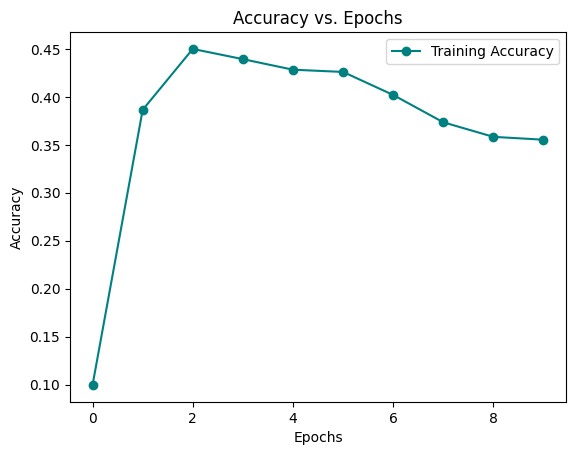

In [157]:
# plot acccuracy vs epochs
plt.figure()
plt.plot(hist.history['accuracy'], '-o', color='teal', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()